In [ ]:
from google.colab import files

# Upload the kaggle.json file manually
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [ ]:
import os
import shutil

# Ensure .kaggle directory exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Rename and move the correct file
shutil.move("/content/kaggle (1).json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("✅ Fixed: kaggle.json is now correctly placed and configured!")


✅ Fixed: kaggle.json is now correctly placed and configured!


In [ ]:
# Download the dataset
!kaggle datasets download -d santurini/semantic-segmentation-drone-dataset

# Unzip the dataset
!unzip semantic-segmentation-drone-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset
License(s): other
Archive:  semantic-segmentation-drone-dataset.zip
  inflating: binary_dataset/binary_dataset/images_semantic/000.png  
  inflating: binary_dataset/binary_dataset/images_semantic/001.png  
  inflating: binary_dataset/binary_dataset/images_semantic/002.png  
  inflating: binary_dataset/binary_dataset/images_semantic/003.png  
  inflating: binary_dataset/binary_dataset/images_semantic/004.png  
  inflating: binary_dataset/binary_dataset/images_semantic/005.png  
  inflating: binary_dataset/binary_dataset/images_semantic/006.png  
  inflating: binary_dataset/binary_dataset/images_semantic/008.png  
  inflating: binary_dataset/binary_dataset/images_semantic/011.png  
  inflating: binary_dataset/binary_dataset/images_semantic/013.png  
  inflating: binary_dataset/binary_dataset/images_semantic/014.png  
  inflating: binary_dataset/binary_dataset/images_semantic/015.png  
  inflating: 

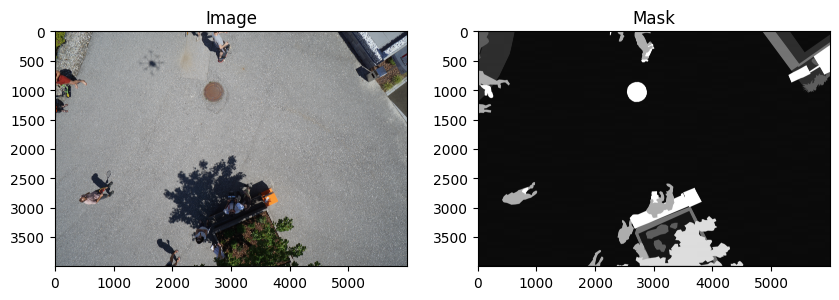

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define dataset paths
image_dir = "/content/semantic_drone_dataset/semantic_drone_dataset/original_images"
mask_dir = "/content/semantic_drone_dataset/semantic_drone_dataset/label_images_semantic"

# List available images and masks
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Display one sample image and its mask
sample_image = cv2.imread(os.path.join(image_dir, image_files[0]))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_mask = cv2.imread(os.path.join(mask_dir, mask_files[0]), cv2.IMREAD_GRAYSCALE)

# Plot the image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image)
axes[0].set_title("Image")
axes[1].imshow(sample_mask, cmap="gray")
axes[1].set_title("Mask")
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define transformation for images and masks
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image
    transforms.ToTensor(),  # Convert to tensor (scales to [0,1])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize mask
    transforms.ToTensor(),  # Convert to tensor (but keep integer values)
])

# Custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")  # Load image
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Create dataset and dataloader
dataset = SegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check shape of a batch
images, masks = next(iter(dataloader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


In [ ]:
import torch
import torchvision.models.segmentation as models

# Load FCN with a ResNet-50 backbone
fcn_model = models.fcn_resnet50(pretrained=True)

# Modify the final classification layer to match the number of classes in our dataset
num_classes = 2  # Background + Object (binary segmentation)
fcn_model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn_model = fcn_model.to(device)

print(fcn_model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 86.7MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=0.0001)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    fcn_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Move to GPU

        optimizer.zero_grad()  # Clear gradients
        outputs = fcn_model(images)["out"]  # Forward pass
        loss = criterion(outputs, masks.squeeze(1))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


Epoch [1/10], Loss: 0.2065
Epoch [2/10], Loss: 0.0565
Epoch [3/10], Loss: 0.0289
Epoch [4/10], Loss: 0.0172
Epoch [5/10], Loss: 0.0114
Epoch [6/10], Loss: 0.0080
Epoch [7/10], Loss: 0.0060
Epoch [8/10], Loss: 0.0047
Epoch [9/10], Loss: 0.0037
Epoch [10/10], Loss: 0.0030


In [ ]:
!pip install segmentation-models-pytorch --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import segmentation_models_pytorch as smp


In [ ]:
# Load U-Net with ResNet-34 encoder (pretrained on ImageNet)
unet_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 403MB/s]


In [ ]:
import torch.optim as optim

# Define loss functions
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = torch.nn.BCEWithLogitsLoss()

# Custom function to combine both losses
def combined_loss(output, target):
    return dice_loss(output, target) + bce_loss(output, target)

# Define optimizer
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10  # Define the number of epochs

for epoch in range(num_epochs):
    unet_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device, dtype=torch.float32)  # Move to GPU

        optimizer.zero_grad()  # Clear gradients
        outputs = unet_model(images)  # Forward pass
        loss = combined_loss(outputs, masks)  # Compute combined loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


Epoch [1/10], Loss: 0.8112
Epoch [2/10], Loss: 0.4130
Epoch [3/10], Loss: 0.4026
Epoch [4/10], Loss: 0.3944
Epoch [5/10], Loss: 0.3885
Epoch [6/10], Loss: 0.3801
Epoch [7/10], Loss: 0.3779
Epoch [8/10], Loss: 0.3685
Epoch [9/10], Loss: 0.3620
Epoch [10/10], Loss: 0.3567


In [ ]:
from torch.utils.data import DataLoader, random_split

# Define dataset split (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
fcn_model.eval()  # Set the model to evaluation mode

val_loss = 0.0
num_samples = 0

with torch.no_grad():  # No need to calculate gradients
    for images, masks in val_dataloader:  # Iterate through validation dataset
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Move data to GPU

        outputs = fcn_model(images)["out"]  # Forward pass
        loss = criterion(outputs, masks.squeeze(1))  # Compute loss

        val_loss += loss.item() * images.size(0)  # Accumulate loss
        num_samples += images.size(0)

# Compute average validation loss
val_loss /= num_samples
print(f"Validation Loss: {val_loss:.4f}")


Validation Loss: 0.0027


In [ ]:
outputs = fcn_model(images)["out"]
preds = torch.sigmoid(outputs)  # Apply sigmoid
preds = (preds > 0.5).float()  # Convert to binary mask
preds = preds[:, 0, :, :]  # Select only the first channel (Shape becomes [batch, 256, 256])


In [ ]:
preds = torch.argmax(outputs, dim=1)  # Get class with highest probability


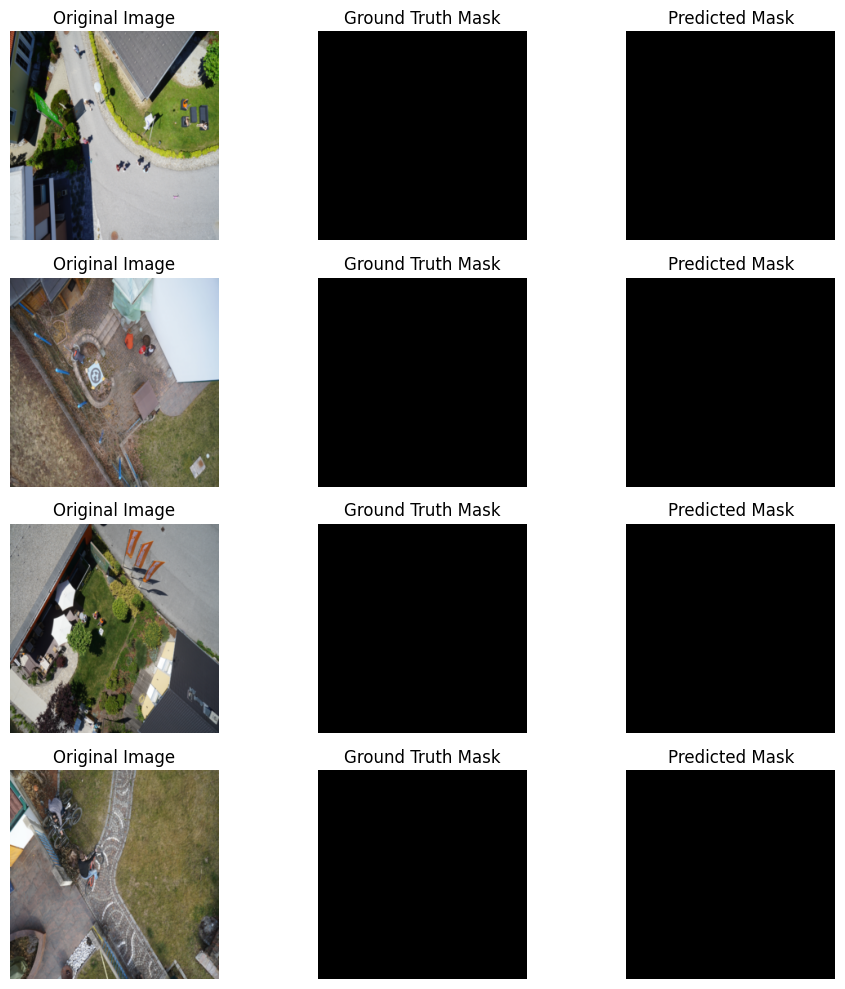

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and masks from the validation set
images, masks = next(iter(val_dataloader))
images, masks = images.to(device), masks.to(device, dtype=torch.long)

# Set model to evaluation mode
fcn_model.eval()

# Get predictions
with torch.no_grad():
    outputs = fcn_model(images)["out"]
    preds = torch.sigmoid(outputs)  # Apply sigmoid activation
    preds = (preds > 0.5).float()  # Convert to binary mask
    preds = preds[:, 0, :, :]  # Select first channel (Now shape is [batch, 256, 256])

# Plot original images, ground truth masks, and predictions
fig, axes = plt.subplots(len(images), 3, figsize=(10, 10))

for i in range(len(images)):
    axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Original image
    axes[i, 0].set_title("Original Image")

    axes[i, 1].imshow(masks[i].cpu().numpy().squeeze(), cmap="gray")  # Ground truth
    axes[i, 1].set_title("Ground Truth Mask")

    axes[i, 2].imshow(preds[i].cpu().numpy(), cmap="gray")  # Predicted mask
    axes[i, 2].set_title("Predicted Mask")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import segmentation_models_pytorch as smp

# Define the DeepLabV3+ model
deeplab_model = smp.DeepLabV3Plus(
    encoder_name="resnet50",  # Backbone
    encoder_weights="imagenet",  # Pretrained on ImageNet
    in_channels=3,  # Input channels (RGB)
    classes=1  # Output classes (binary segmentation)
).to("cuda" if torch.cuda.is_available() else "cpu")

print(deeplab_model)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
import torch.optim as optim
import segmentation_models_pytorch.losses as smp_losses

# Loss function: Combine Dice loss and Binary Cross-Entropy loss
dice_loss = smp_losses.DiceLoss(mode="binary")
bce_loss = torch.nn.BCEWithLogitsLoss()

def combined_loss(output, target):
    return dice_loss(output, target) + bce_loss(output, target)

# Define optimizer
optimizer = optim.Adam(deeplab_model.parameters(), lr=0.001)


In [ ]:
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
batch_size = 4

# Load dataset
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    deeplab_model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = deeplab_model(images)  # Forward pass
        loss = combined_loss(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.5762
Epoch [2/10], Loss: 0.3901
Epoch [3/10], Loss: 0.3837
Epoch [4/10], Loss: 0.3776
Epoch [5/10], Loss: 0.3657
Epoch [6/10], Loss: 0.3557
Epoch [7/10], Loss: 0.3650
Epoch [8/10], Loss: 0.3647
Epoch [9/10], Loss: 0.3496
Epoch [10/10], Loss: 0.3460


In [ ]:
# Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:

# Define Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [ ]:
# Define dataset paths
image_dir = "/content/semantic_drone_dataset/semantic_drone_dataset/original_images"
mask_dir = "/content/semantic_drone_dataset/semantic_drone_dataset/label_images_semantic"


In [ ]:
dataset = SegmentationDataset(image_dir, mask_dir, transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Load Pretrained Models
fcn = models.fcn_resnet50(pretrained=True)
unet = models.deeplabv3_resnet50(pretrained=True)  # Using DeepLabV3 as a proxy for U-Net
deeplab = models.deeplabv3_resnet101(pretrained=True)

# Set Models to Evaluation Mode
fcn.eval()
unet.eval()
deeplab.eval()

# Function to Visualize Results
def visualize_results(image, mask, predictions, titles):
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Input Image")
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")

    for i in range(2, 4):
        axs[i].imshow(predictions[i-2].squeeze().detach().numpy(), cmap='gray')
        axs[i].set_title(titles[i-2])

    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_

In [ ]:
# Iterate Through Dataset
for images, masks in dataloader:
    with torch.no_grad():
        fcn_out = fcn(images)['out']
        unet_out = unet(images)['out']
        deeplab_out = deeplab(images)['out']

    visualize_results(images[0], masks[0], [fcn_out[0], unet_out[0]], ["FCN Output", "DeepLab Output"])
    break  # Only visualize first batch


FileNotFoundError: [Errno 2] No such file or directory: 's'